In [1]:
%pylab inline
import numpy as np
import pandas as pd
from scipy import stats
from scipy import optimize
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import datetime as dt
from calendar import monthrange

Populating the interactive namespace from numpy and matplotlib


In [17]:
data = pd.read_csv('data_original/common.csv', parse_dates=['Date'])

#Для каждого филиала для каждого месяца
#Строим таблицу (День в месяце X количество заказов)

res = dict()
branches = data.Point.unique()
for branch in branches:
    branch_data = data[data.Point == branch]
    max_date = branch_data.Date.max()
    min_date = branch_data.Date.min()
    max_date -= dt.timedelta(days=max_date.day-1)
    min_date -= dt.timedelta(days=min_date.day-1)
    date = min_date
    while date <= max_date:
        next_date = date + dt.timedelta(days=monthrange(date.year, date.month)[1])
        part = branch_data[np.logical_and(branch_data.Date >= date,  branch_data.Date < next_date)]                      
        count = pd.DataFrame()
        count['Count'] = part.Count
        count.index = part.Date.apply(lambda x: x.day)
        count = count[pd.notnull(count.Count)]
        res[(date, branch)] = count
        date = next_date       

KeyboardInterrupt: 

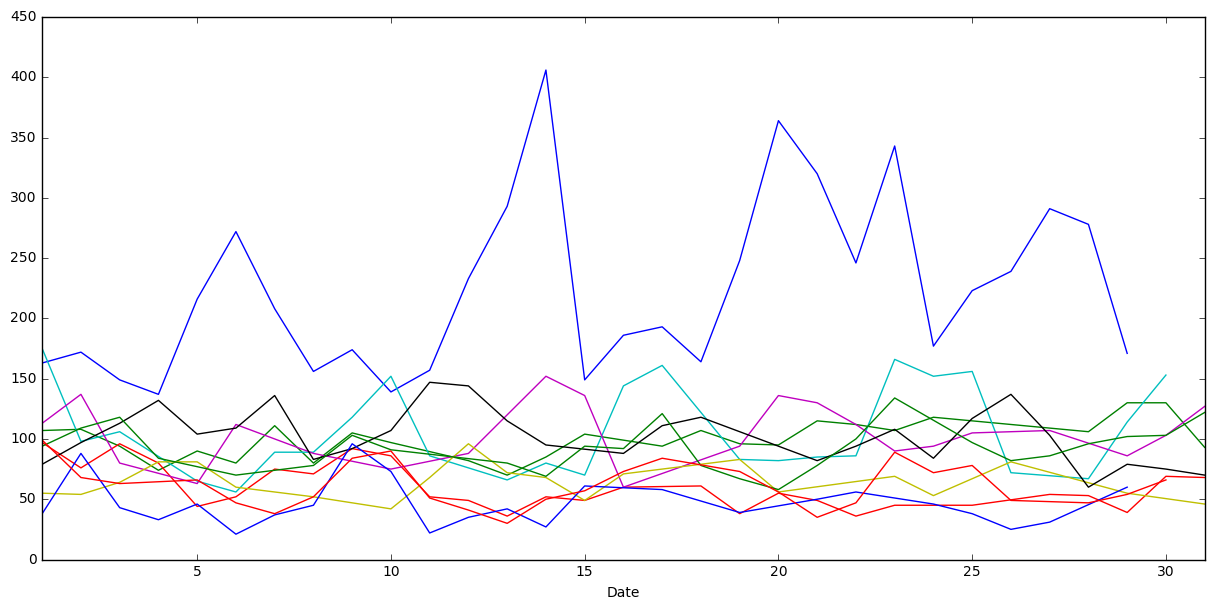

In [3]:
plt.figure(figsize(15,7))
for  val in list(res.items())[:10]:
    val[1].Count.plot()

pylab.show()

In [10]:
target = pd.read_csv('data_transform/target.csv')
data = pd.read_csv('data_original/common.csv', parse_dates=['Date'])
train_data = data[target.IsTrain == 1]

sequences = list()
progress = 0
for branch_name in train_data.Point.unique():
    branch_train = train_data[train_data.Point == branch_name]
    sequence = list()
    
    for i in zip(branch_train.index[:-1], branch_train.index[1:]):    
        if (branch_train.loc[i[1], 'Date'] - branch_train.loc[i[0], 'Date']).days == 1: 
            sequence.append(i[0])
        else:
            if len(sequence) > 6:
                sequences.append(branch_train.loc[sequence])
                sequence = list()
    print(progress)
    progress += 1
len(sequences)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113


2785

In [11]:
validate_data = data[target.IsValidation == 1]
branch_validate = validate_data[validate_data.Point == 'Сыктывкар-1']

vnt_data = data[np.logical_or(target.IsValidation == 1, target.IsTrain == 1)]
vnt_branch = vnt_data[vnt_data.Point == 'Сыктывкар-1']

validate_indexes = pd.Series(branch_validate.index)

to_predict = list()

for i in branch_validate.index:
    left = np.where(vnt_branch.index == i)
    right = left[0] + 7
    if left > 0 & right < vnt_branch.index.size:
        indexes = vnt_branch.index[left[0]:right+1]
        if (np.sum(pd.Series(indexes).isin(validate_indexes)) == 1) & ((vnt_branch.loc[indexes[-1], 'Date'] - vnt_branch.loc[indexes[0], 'Date']).days == 7):
            to_predict.append(vnt_branch.loc[indexes])
        
    

/opt/anaconda3/lib/python3.5/site-packages/pandas/indexes/base.py:1269: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
  return promote(getitem(key))


In [12]:
def f(x, a, b):
    return a + b*x

def lsm (x, y):
    n = x.shape[0]
    a = (n * np.sum(x * y) - np.sum(x) * np.sum(y)) / (n * np.sum(x * x) - np.sum(x)**2)
    b = (np.sum(y) - a * np.sum(x)) / n
    return a, b

/opt/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


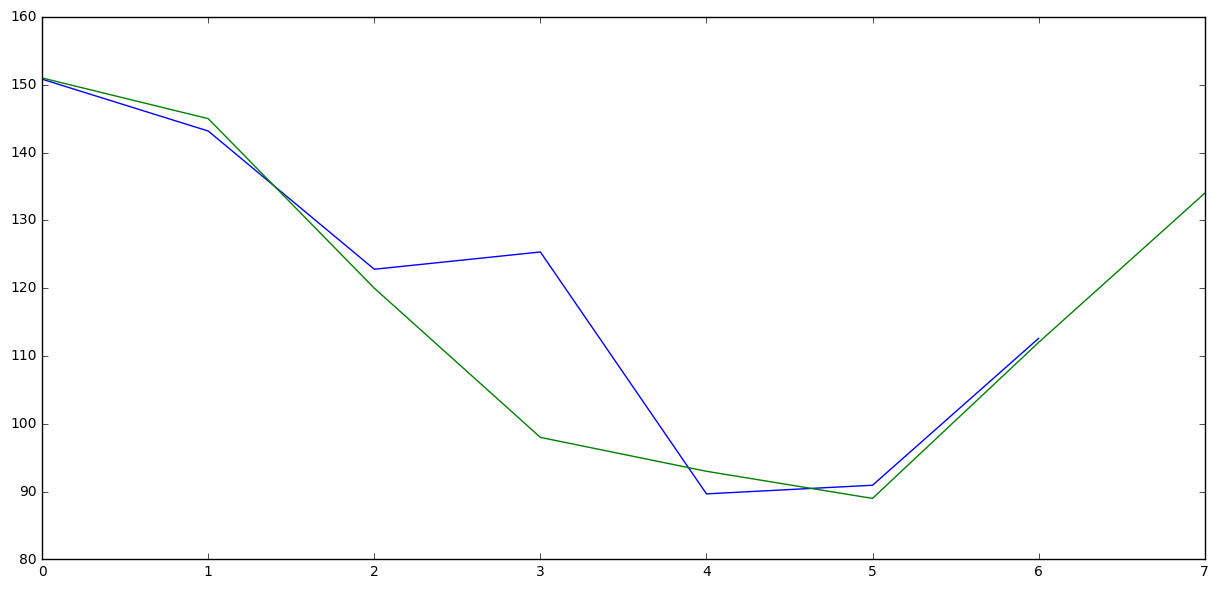

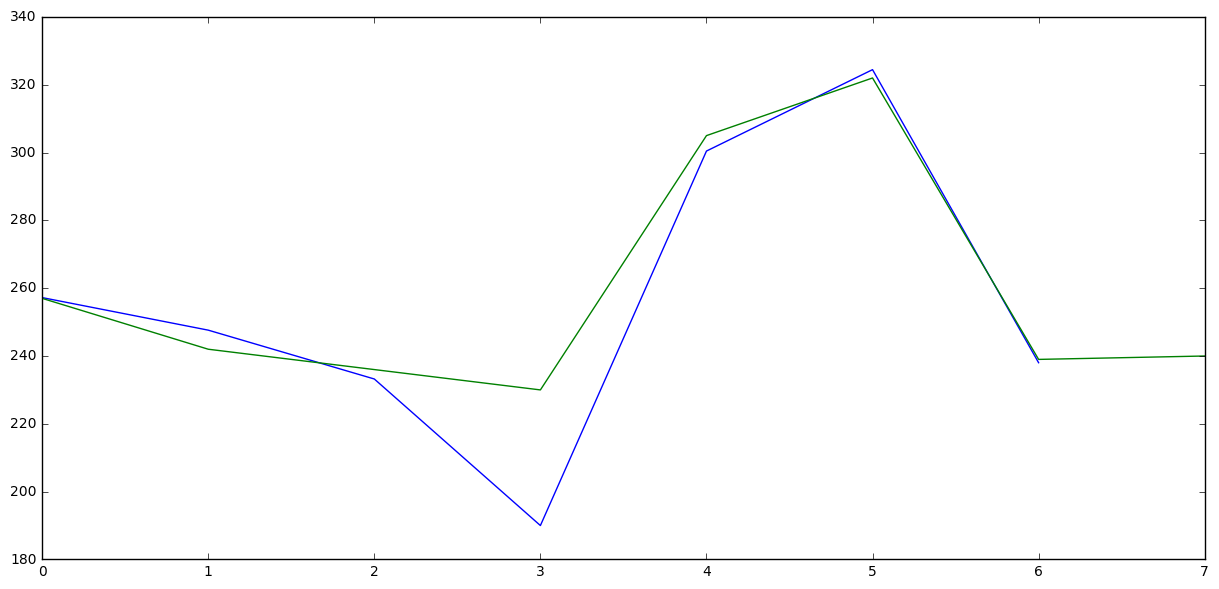

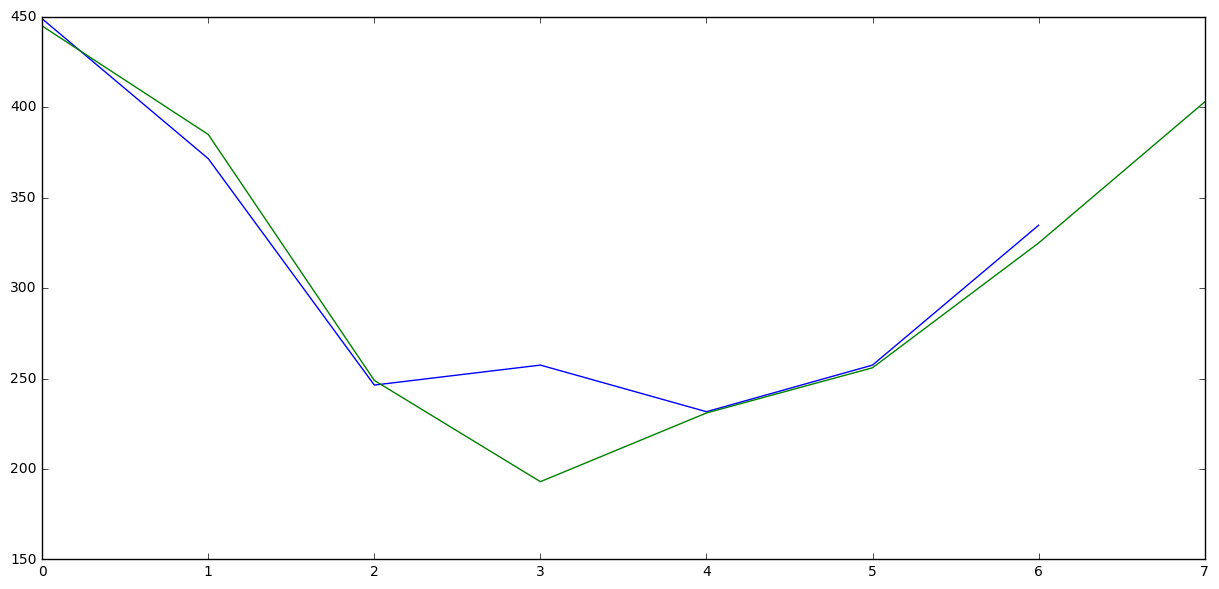

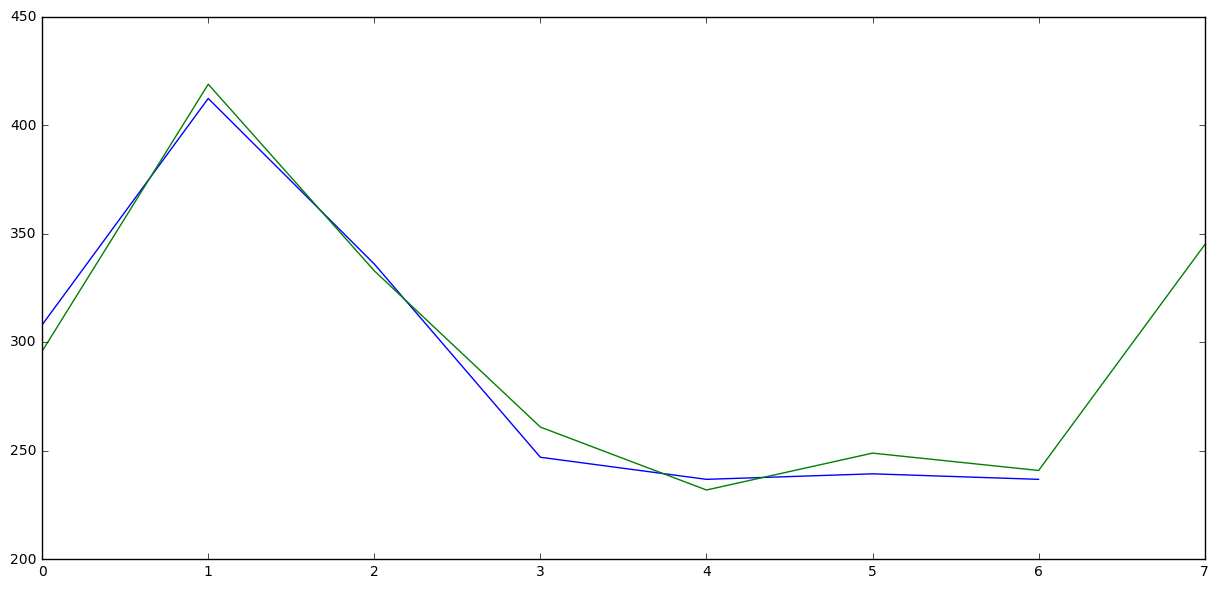

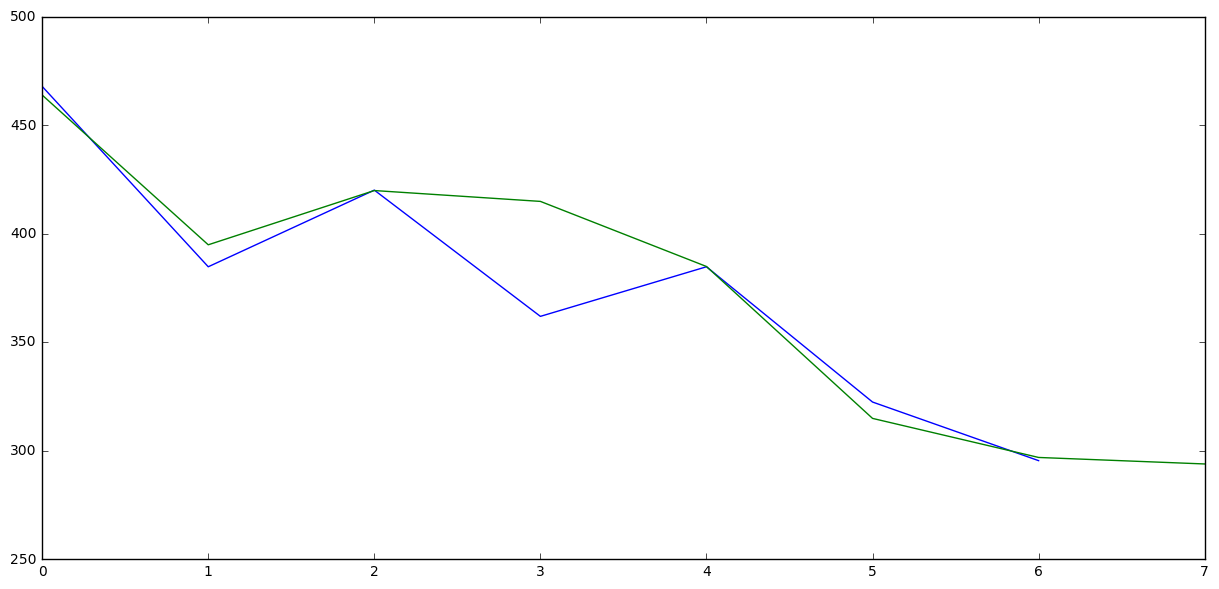

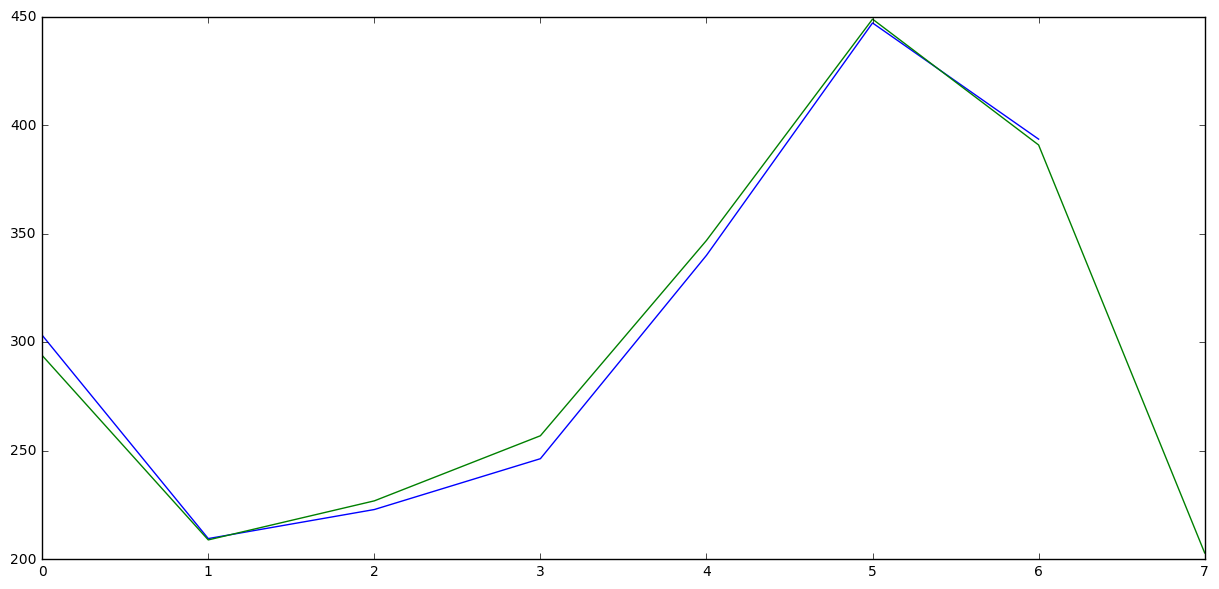

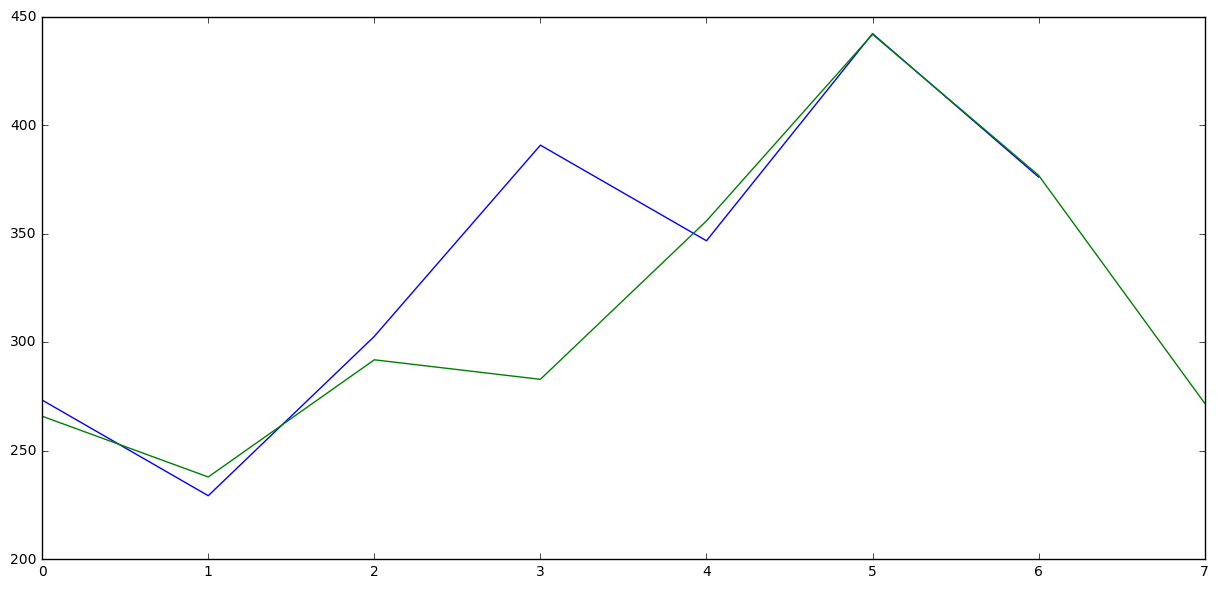

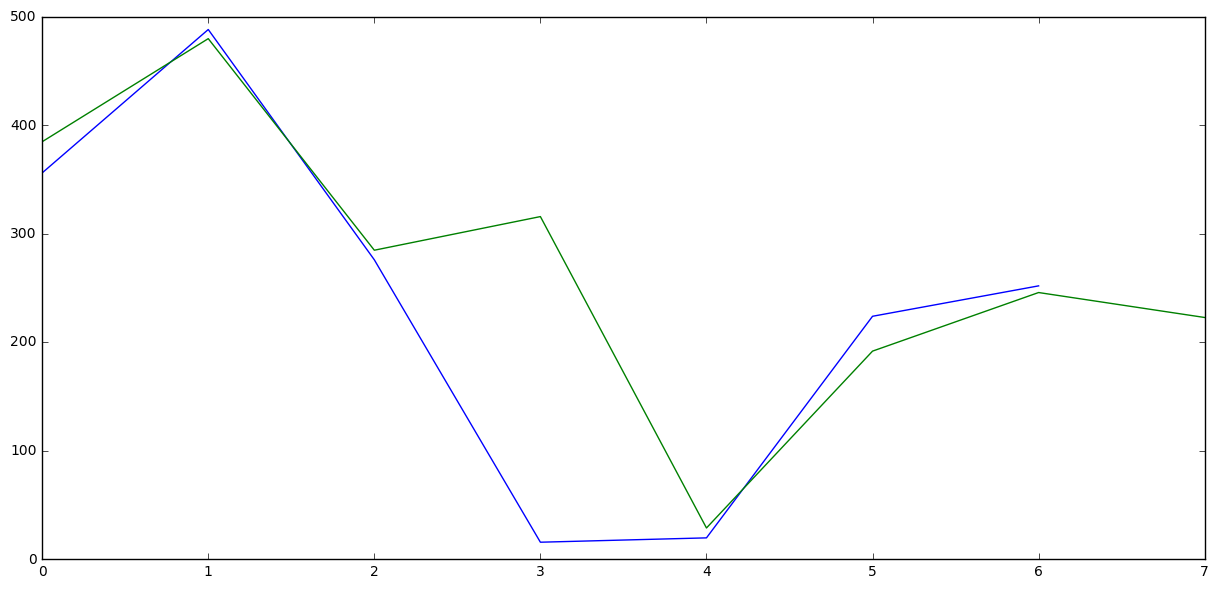

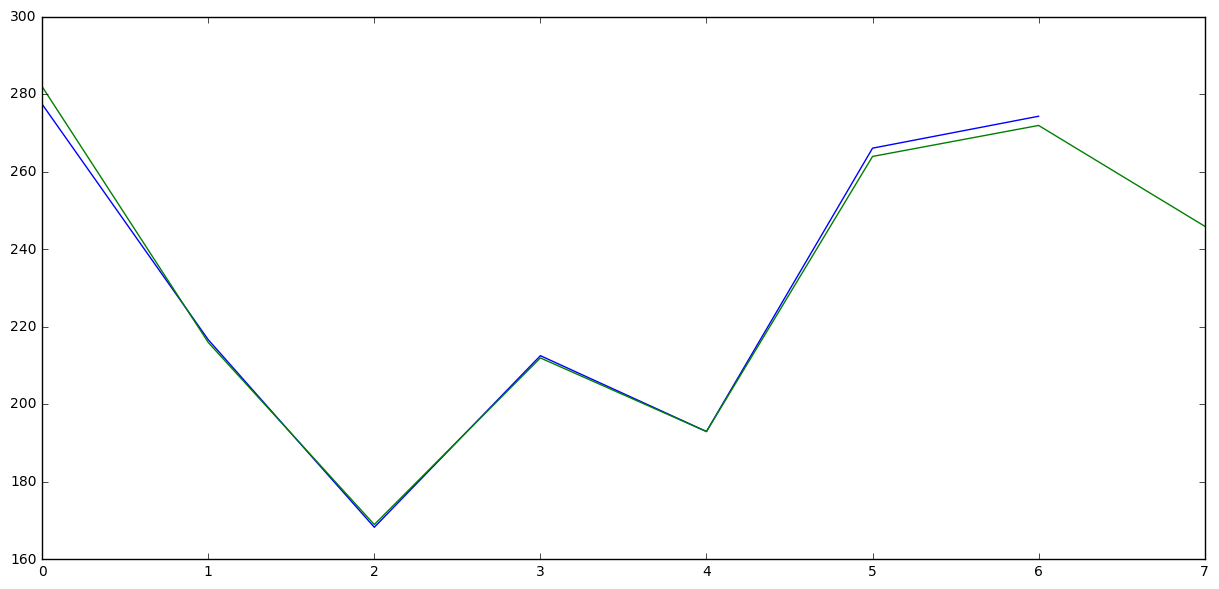

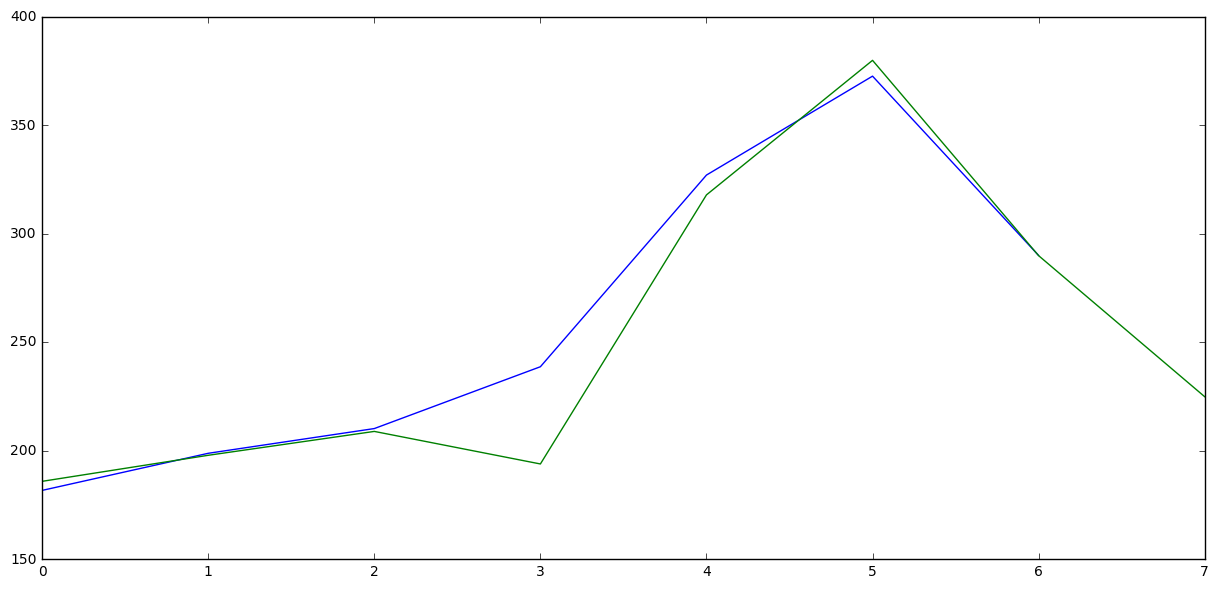

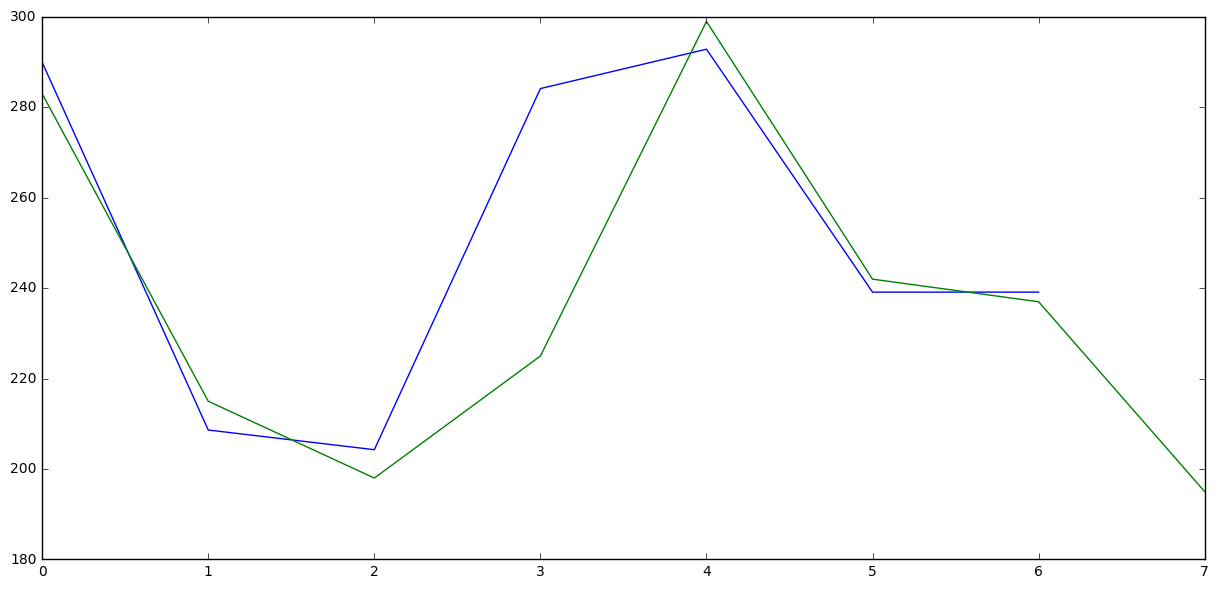

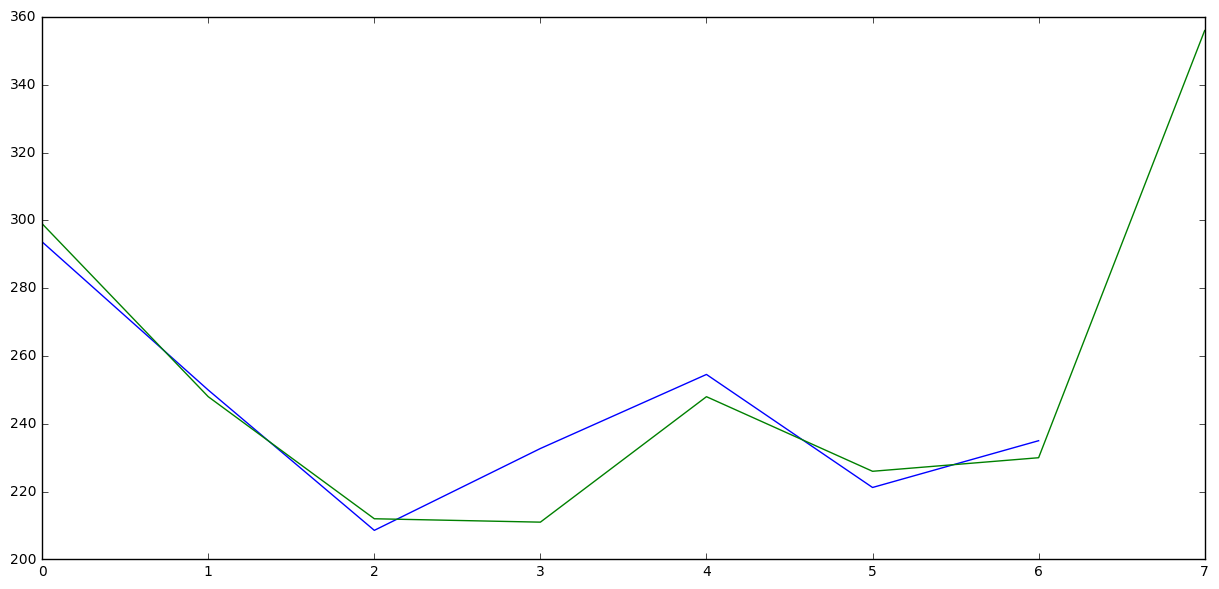

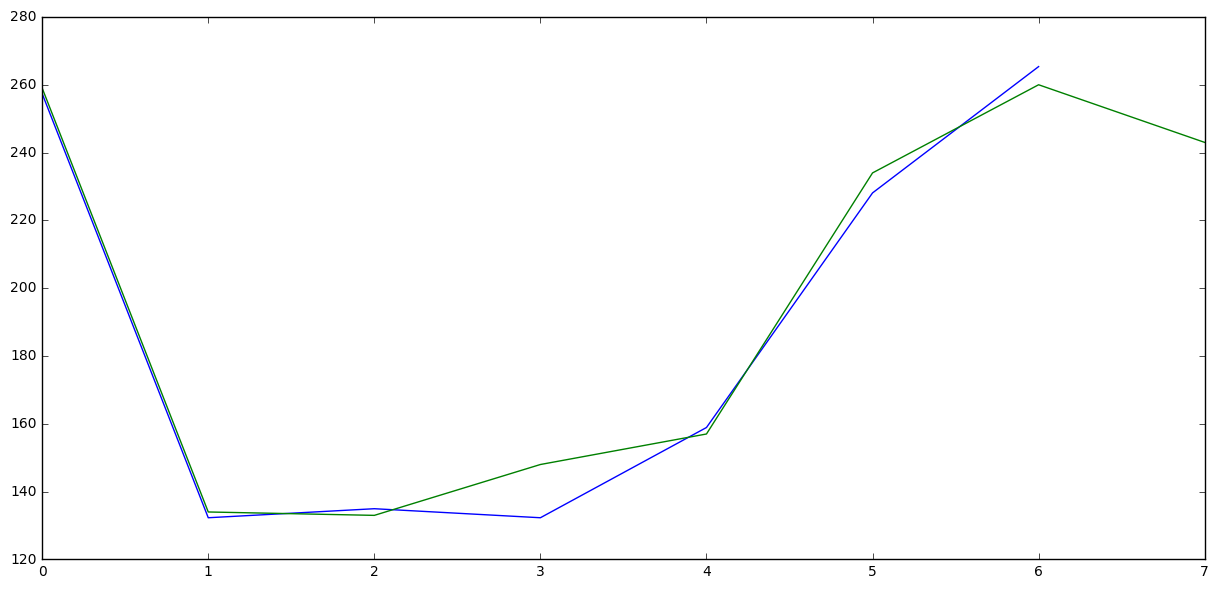

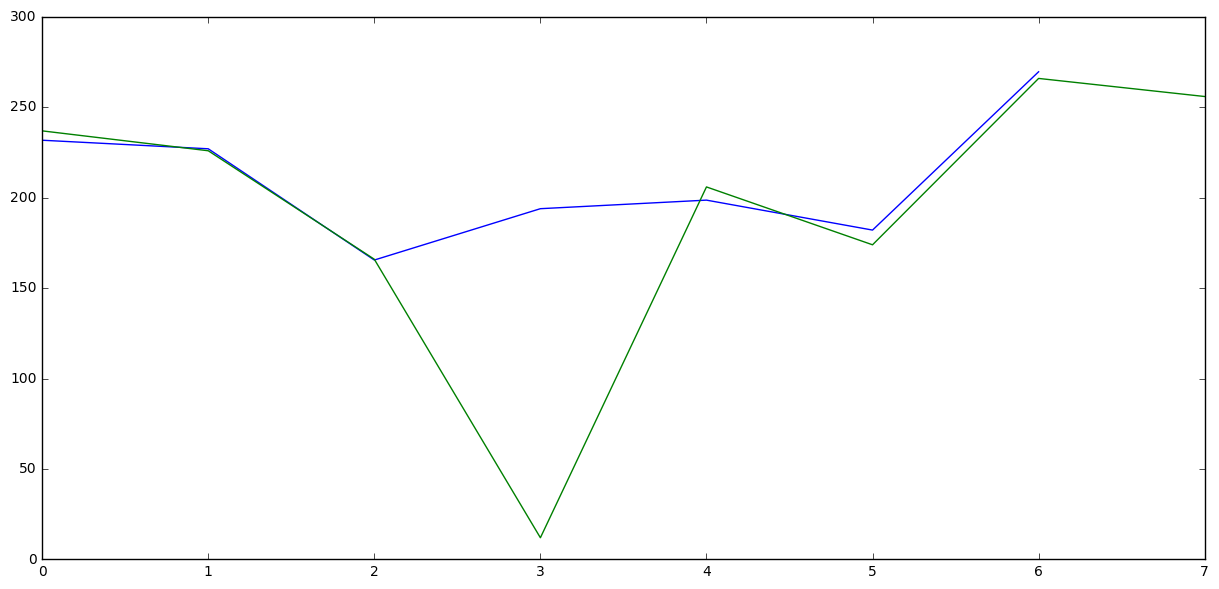

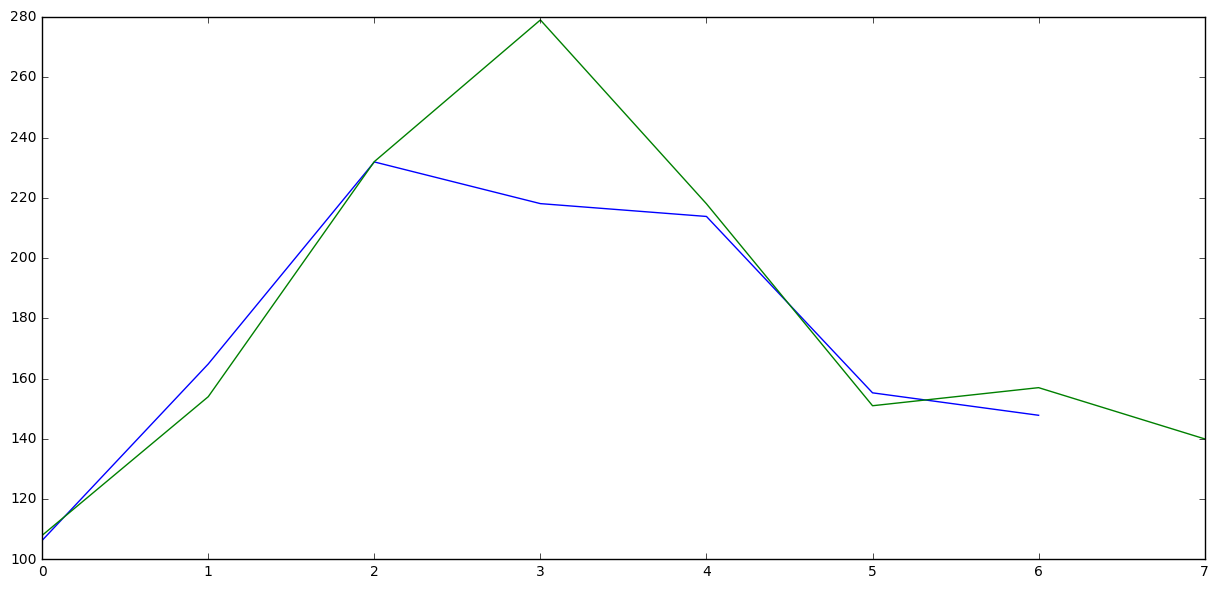

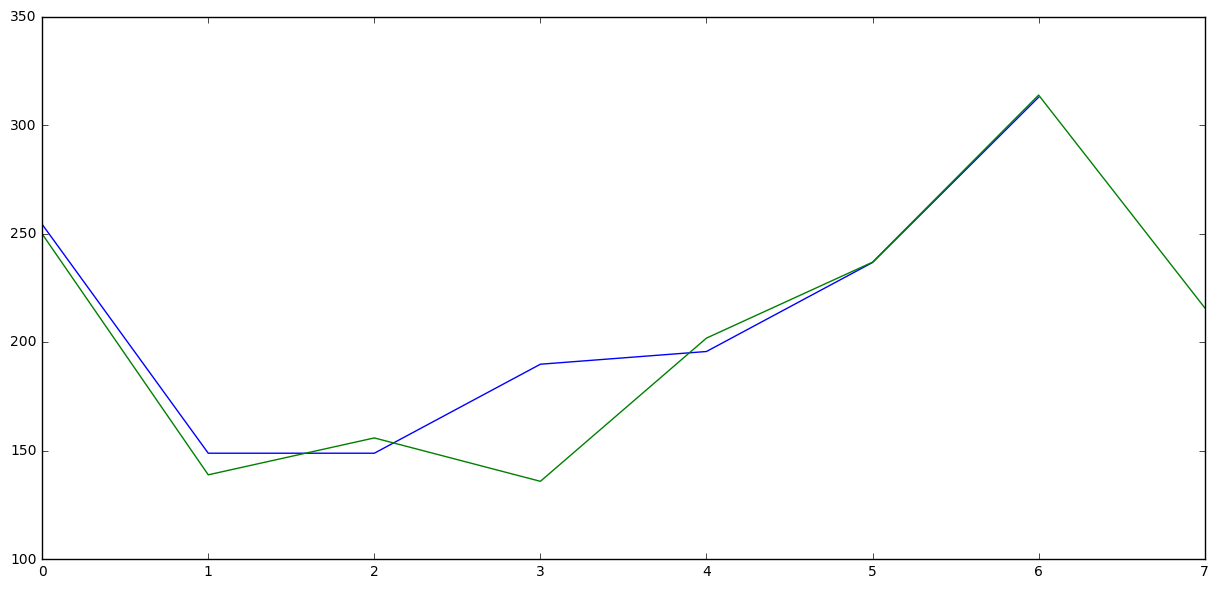

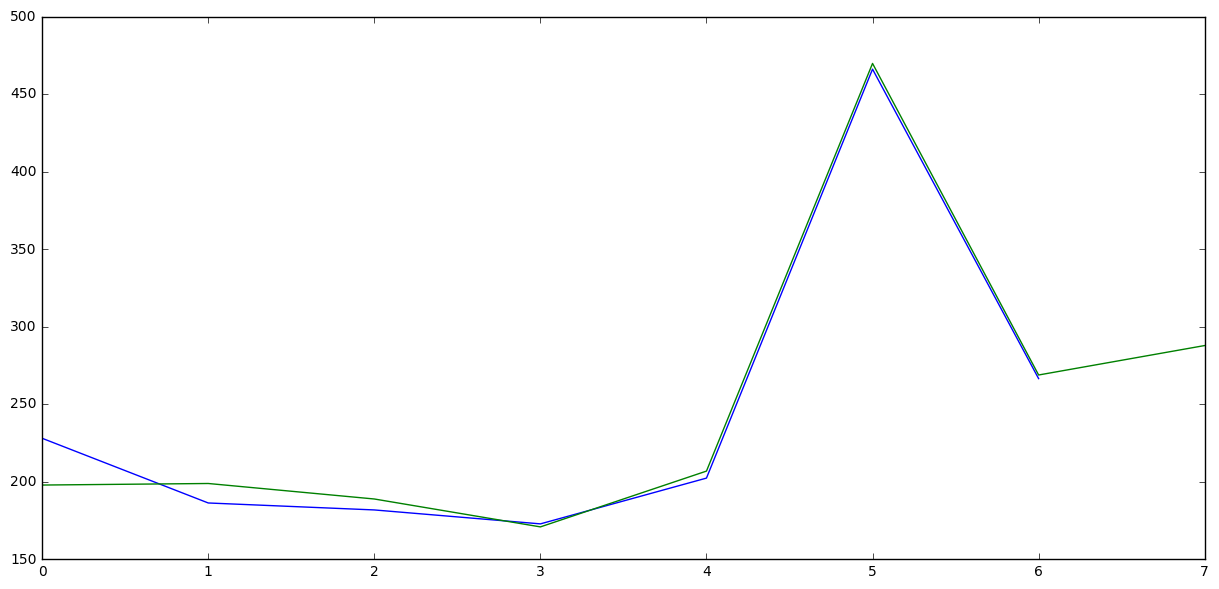

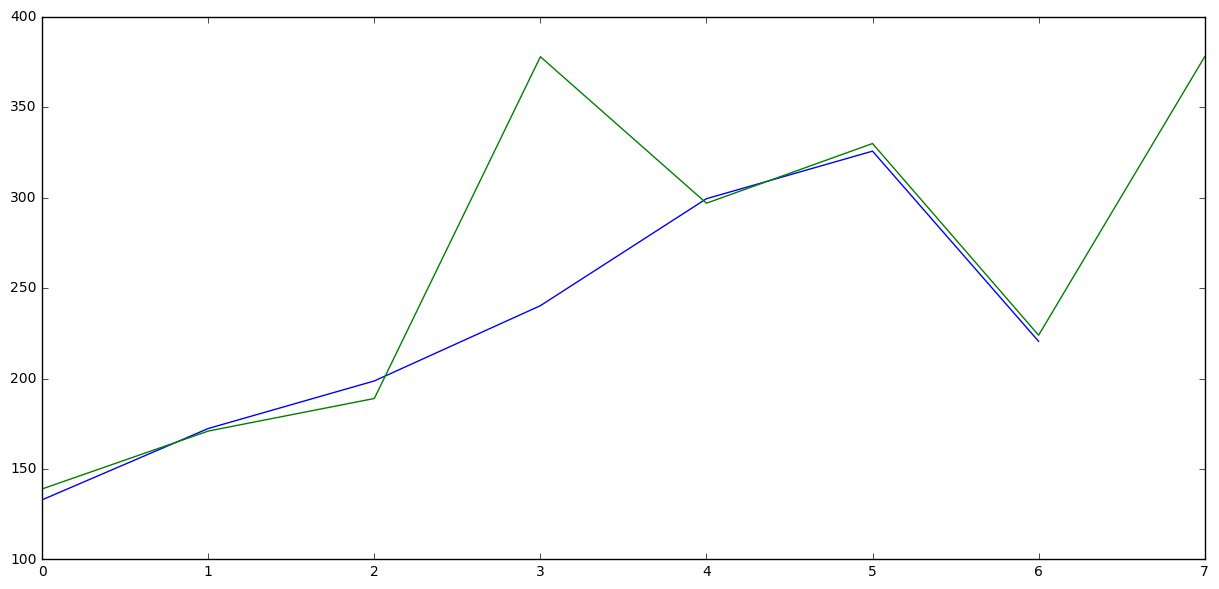

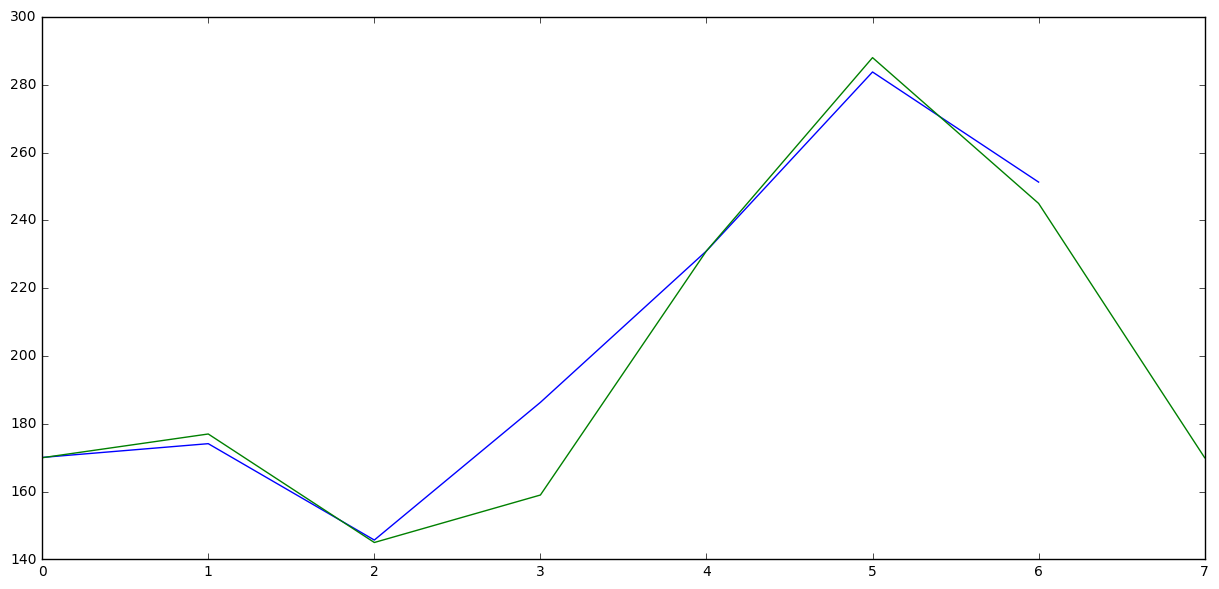

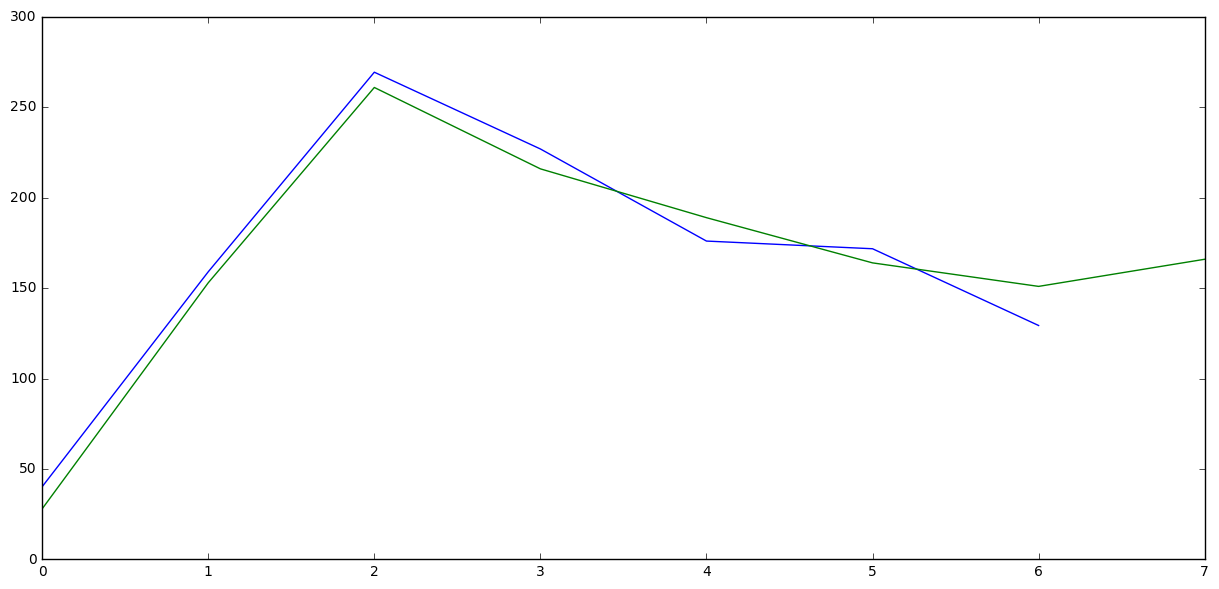

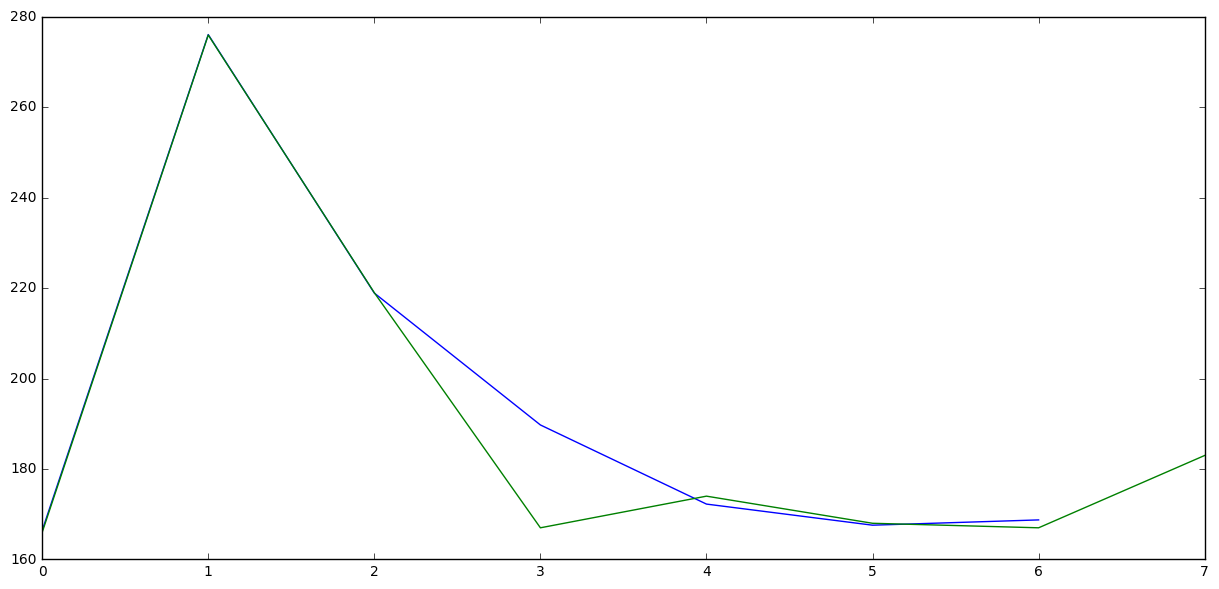

In [13]:
err = 0
for predict in to_predict:
    plt.figure(figsize(15,7))
    predict = predict.Count.as_matrix()
    sim1 = predict[[0, 1, 2, 4, 5, 6]]
    max_corr = 0;
    for sequence in sequences:
        sequence = sequence.Count.as_matrix()
        for i in range(len(sequence)-7):
            sim2 = sequence[[i, i+1, i+2, i+4, i+5, i+6]]
            corr = abs(np.corrcoef(sim1, sim2)[0][1])
            if max_corr < corr:
                max_corr = corr
                max_sim = sequence[range(i, i+7)]
    if max_corr > 0.9:
        a, b = lsm(max_sim[[0, 1, 2, 4, 5, 6]], sim1)
        predicted = f(max_sim, b ,a)
        err = abs(predict[3] - predicted[3])
        plt.plot(predicted)
    plt.plot(predict)
pylab.show()      
    
    

In [5]:
import numpy as np
from scipy import optimize
a = np.array([1, 2])
b = np.array([12, 14])

In [2]:
from sklearn.linear_model import LinearRegression

In [ ]:
optimize()

In [11]:
lsm (a, b)

(2.0, 10.0)